In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB

In [105]:
f = np.genfromtxt('data_banknote_authentication.txt', delimiter=',')
p = pd.read_csv('data_banknote_authentication.txt', names=['variance', 'skeweness', 'curtosis', 'entropy', 'class'])
labels = p.iloc[:,-1]
features = p.iloc[:, :-1]

features.shape, labels.shape

((1372, 4), (1372,))

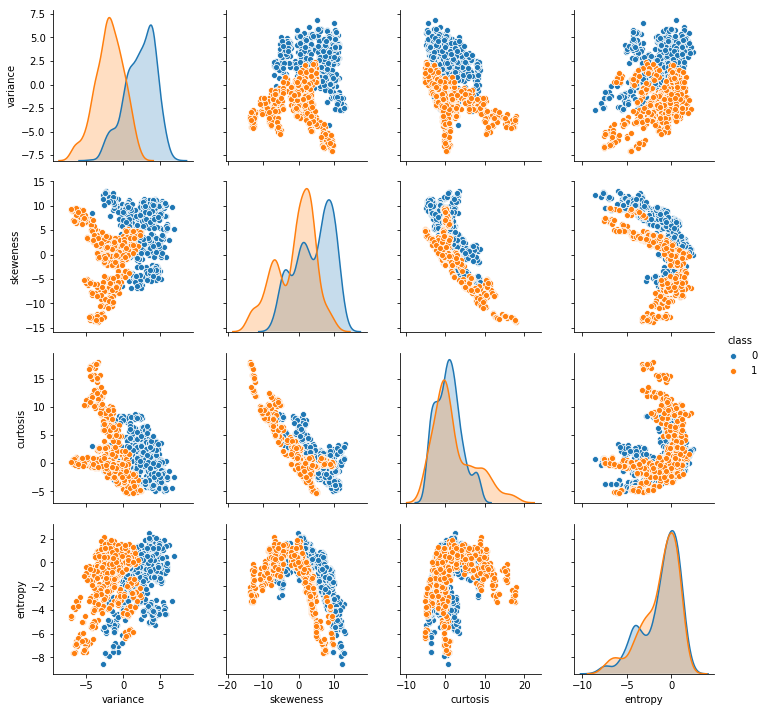

In [140]:
sns.pairplot(p, hue='class', x_vars=['variance', 'skeweness', 'curtosis', 'entropy'], y_vars=['variance', 'skeweness', 'curtosis', 'entropy'])

In [35]:
KF = RepeatedKFold(n_splits=10, random_state=42)

In [68]:
models = {
    'NB': GaussianNB(),
    'LR': LogisticRegression(),
    'SGD': SGDClassifier(),
    'kNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(max_depth=10, random_state=42),
    'RF': RandomForestClassifier(n_estimators=25, random_state=42),
    'linearSVC': SVC(kernel='linear', random_state=42),
    'rbfSVC': SVC(kernel='rbf', random_state=42),
    'MLP': MLPClassifier(random_state=42),
}

In [69]:
def run_models(models):
    df = pd.DataFrame(columns=['name', 'score', 'std'])
    for i, (name, model) in enumerate(models.items()):
        scores = cross_val_score(model, data, labels, cv=KF, scoring='accuracy')
        df.loc[i] = name, np.mean(scores), np.std(scores)
    return df

In [70]:
results = run_models(models)

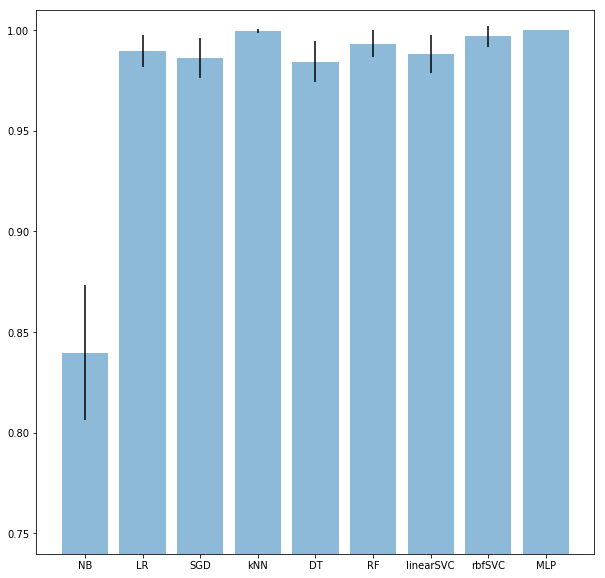

In [75]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(results['name'], results['score'], yerr=results['std'], alpha=0.5)
ax.set_ylim(min(results['score'] - 0.1), 1.01)
plt.show()